In [ ]:
!pip install optuna shap lightgbm catboost -q

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os

# Sklearn imports
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (train_test_split, StratifiedKFold,
                                     cross_val_score, cross_validate, GridSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix,
                             classification_report, ConfusionMatrixDisplay,
                             precision_score, recall_score, f1_score)
from sklearn.ensemble import (RandomForestClassifier, VotingClassifier,
                              StackingClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier, AdaBoostClassifier)
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

# Advanced models
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Hyperparameter optimization
import optuna
from optuna.samplers import TPESampler

# Interpretability
import shap
from sklearn.inspection import permutation_importance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 12.0 MB/s eta 0:00:00


In [ ]:
RANDOM_STATE = 42
TARGET = "Overall_Experience"
FIGSIZE = (10, 6)

In [ ]:
def load_data():
    train_travel = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Traveldata_train.csv')
    train_survey = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Surveydata_train.csv')
    test_travel = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Traveldata_test.csv')
    test_survey = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Surveydata_test.csv')

    train_df = pd.merge(train_travel, train_survey, on='ID')
    test_df = pd.merge(test_travel, test_survey, on='ID')

    return train_df, test_df

def overview(df):
    print("="*60, "\nSHAPE:", df.shape)
    df.info()
    print(f"Dataset Shape: {df.shape}")
    print(f"Duplicates: {df.duplicated().sum()}")
    if TARGET in df.columns:
        print(f"Target classes: {df[TARGET].value_counts().to_dict()}")
    else:
        print("Target column not found in this dataset.")
    print(df.isna().sum().sort_values(ascending=False).head(15))

train_df, test_df = load_data()
overview(train_df)

SHAPE: (94379, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Gender                   94302 non-null  object 
 2   Customer_Type            85428 non-null  object 
 3   Age                      94346 non-null  float64
 4   Type_Travel              85153 non-null  object 
 5   Travel_Class             94379 non-null  object 
 6   Travel_Distance          94379 non-null  int64  
 7   Departure_Delay_in_Mins  94322 non-null  float64
 8   Arrival_Delay_in_Mins    94022 non-null  float64
 9   Overall_Experience       94379 non-null  int64  
 10  Seat_Comfort             94318 non-null  object 
 11  Seat_Class               94379 non-null  object 
 12  Arrival_Time_Convenient  85449 non-null  object 
 13  Catering                 85638 non-null  object 
 14  Pla

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Analyze data types and missing values

# Display data types count
print("\nData Types:")
# Assign train_df to df for subsequent analysis
df = train_df
print(df.dtypes.value_counts())

# Calculate missing values per column
missing = df.isnull().sum().sort_values(ascending=False)

# Calculate missing value percentages
missing_pct = (missing / len(df) * 100).round(2)

# Create summary dataframe
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Missing_Percentage': missing_pct
})

# Display top missing columns (optional: top 15)
print("\nMissing Values Overview (Top 15):")
print(missing_df.head(15))


Data Types:
object     19
int64       3
float64     3
Name: count, dtype: int64

Missing Values Overview (Top 15):
                         Missing_Count  Missing_Percentage
Type_Travel                       9226                9.78
Customer_Type                     8951                9.48
Arrival_Time_Convenient           8930                9.46
Catering                          8741                9.26
Onboard_Service                   7601                8.05
Arrival_Delay_in_Mins              357                0.38
Baggage_Handling                   142                0.15
Online_Support                      91                0.10
Legroom                             90                0.10
CheckIn_Service                     77                0.08
Gender                              77                0.08
Ease_of_Online_Booking              73                0.08
Seat_Comfort                        61                0.06
Departure_Delay_in_Mins             57                0.06

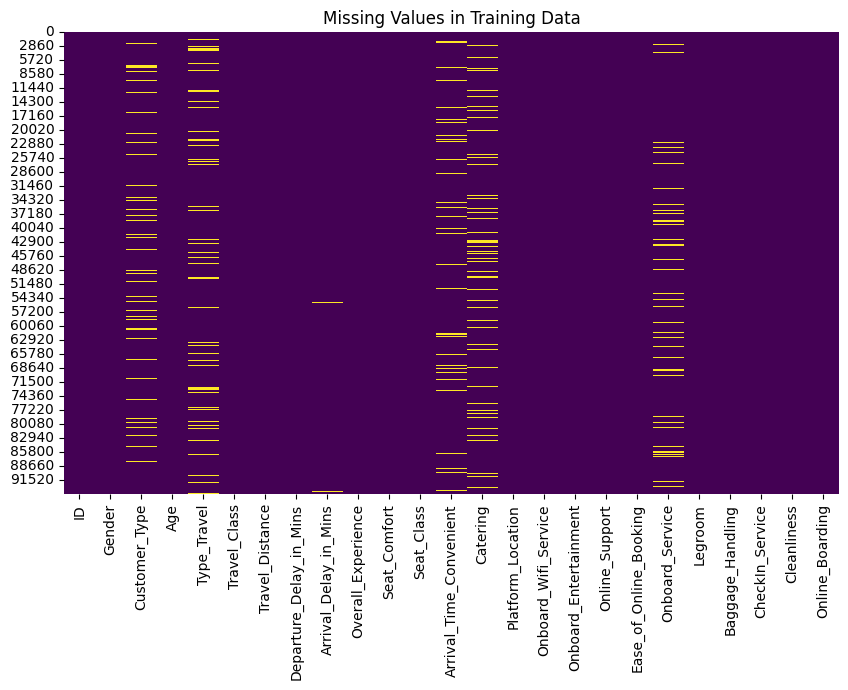

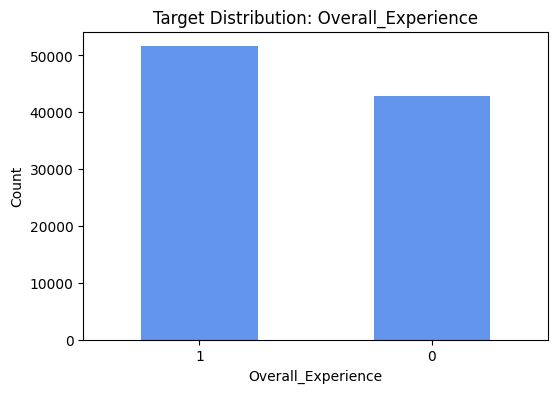

In [ ]:
# Visualize missing values in training data
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isna(), cbar=False, cmap="viridis")
plt.title("Missing Values in Training Data")
plt.show()

# Plot target variable distribution in training data
plt.figure(figsize=(6, 4))
train_df[TARGET].value_counts().plot(kind="bar", color="cornflowerblue")
plt.title("Target Distribution: Overall_Experience")
plt.xlabel("Overall_Experience")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

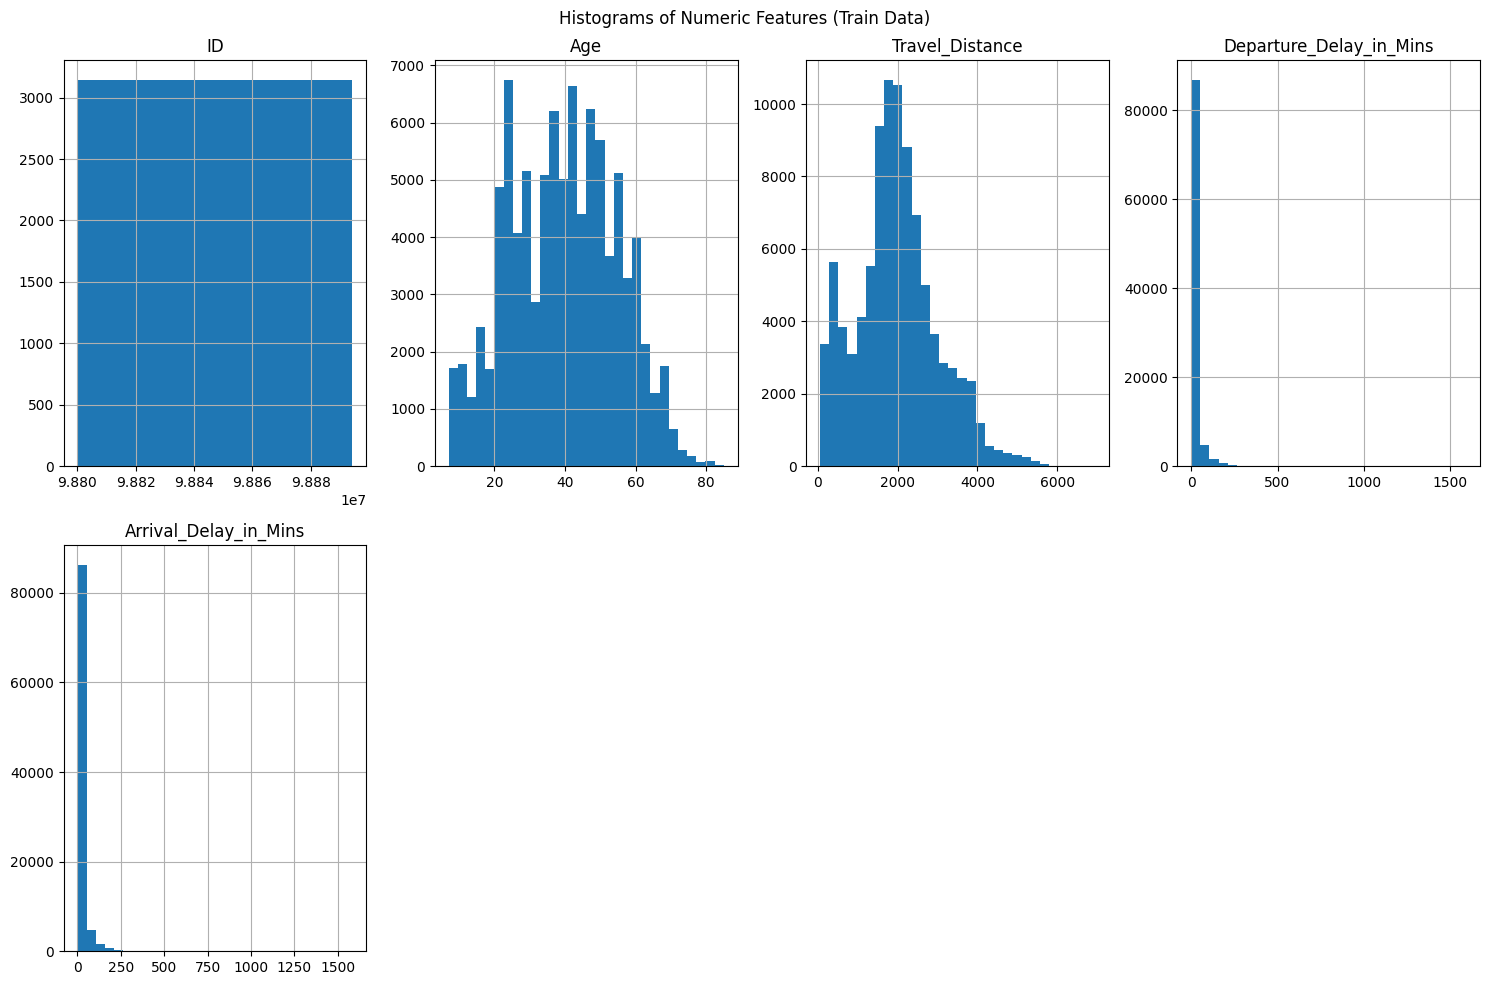

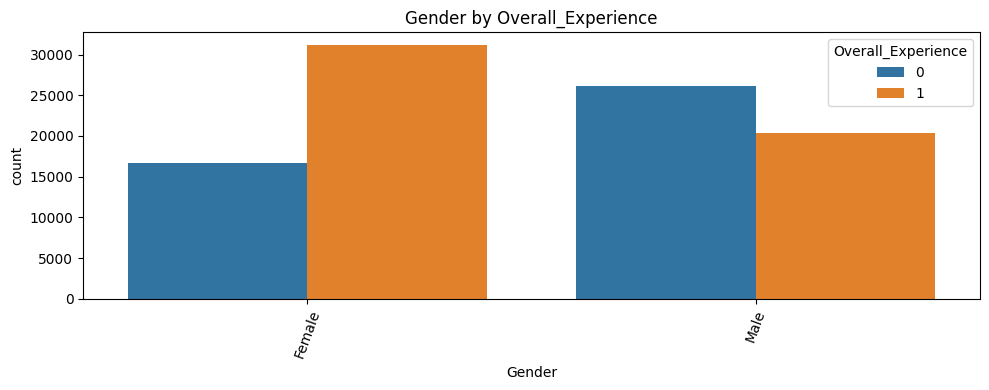

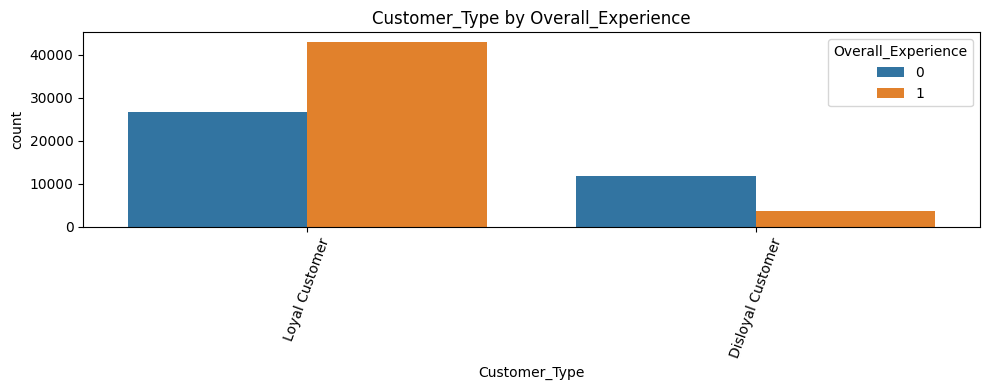

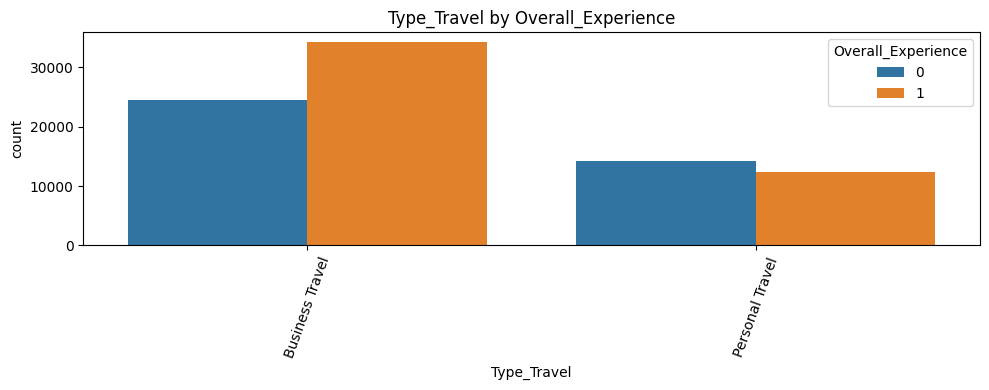

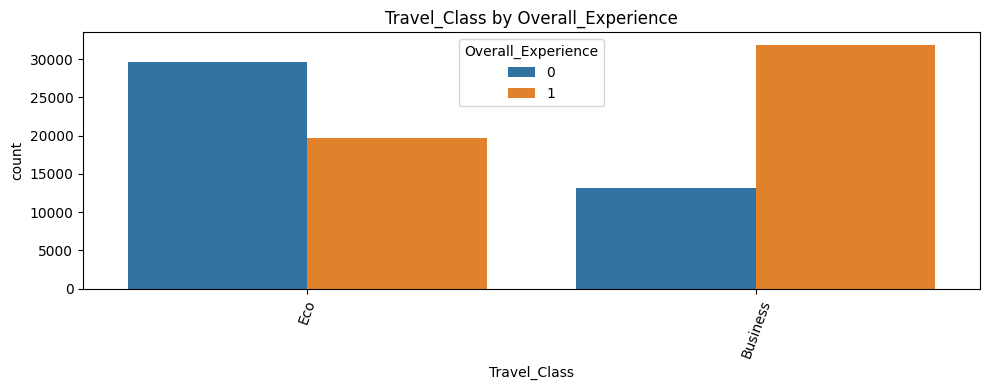

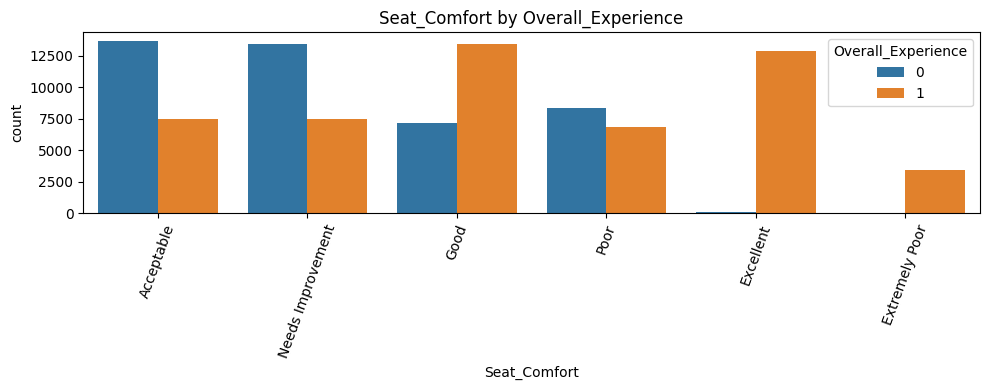

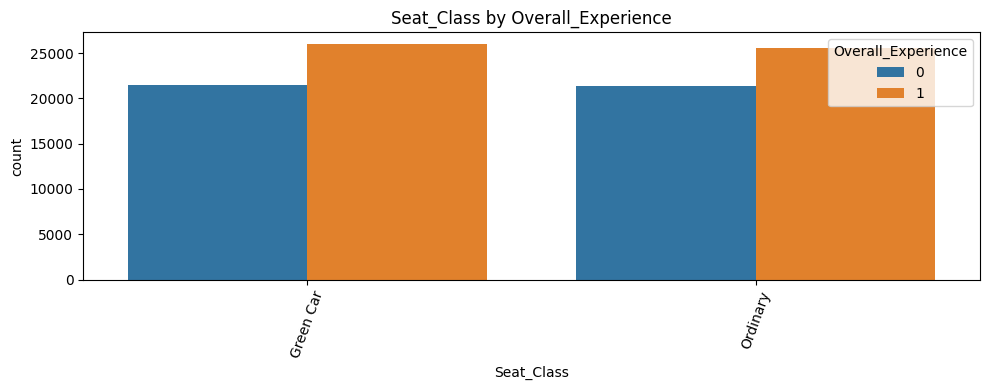

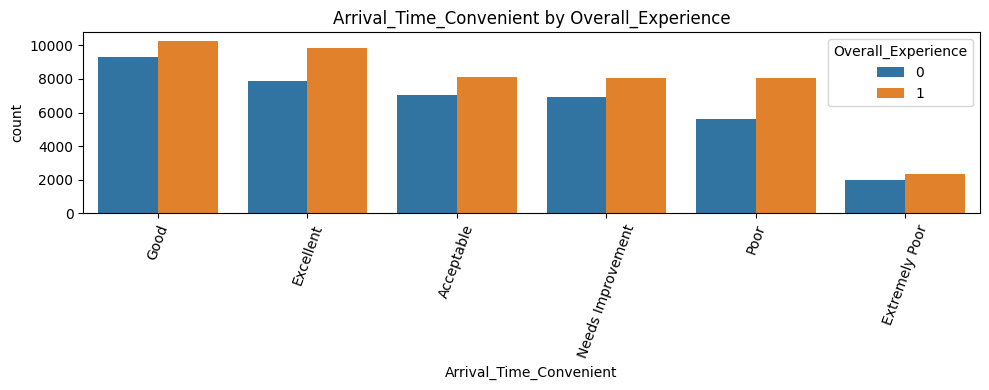

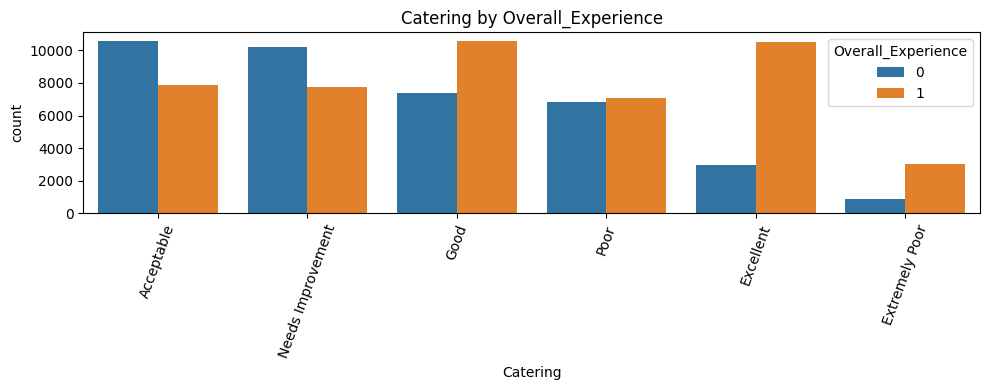

In [ ]:
# Plot histograms for all numeric features except the target
train_df.select_dtypes(include=[np.number]).drop(columns=[TARGET], errors='ignore').hist(
    bins=30, figsize=(15, 10), layout=(-1, 4))
plt.suptitle("Histograms of Numeric Features (Train Data)")
plt.tight_layout()
plt.show()

# Plot count plots for first 8 categorical variables with target hue
for col in train_df.select_dtypes(include="object").columns[:8]:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=train_df, x=col, hue=TARGET, order=train_df[col].value_counts().index[:12])
    plt.xticks(rotation=70)
    plt.title(f"{col} by Overall_Experience")
    plt.tight_layout()
    plt.show()

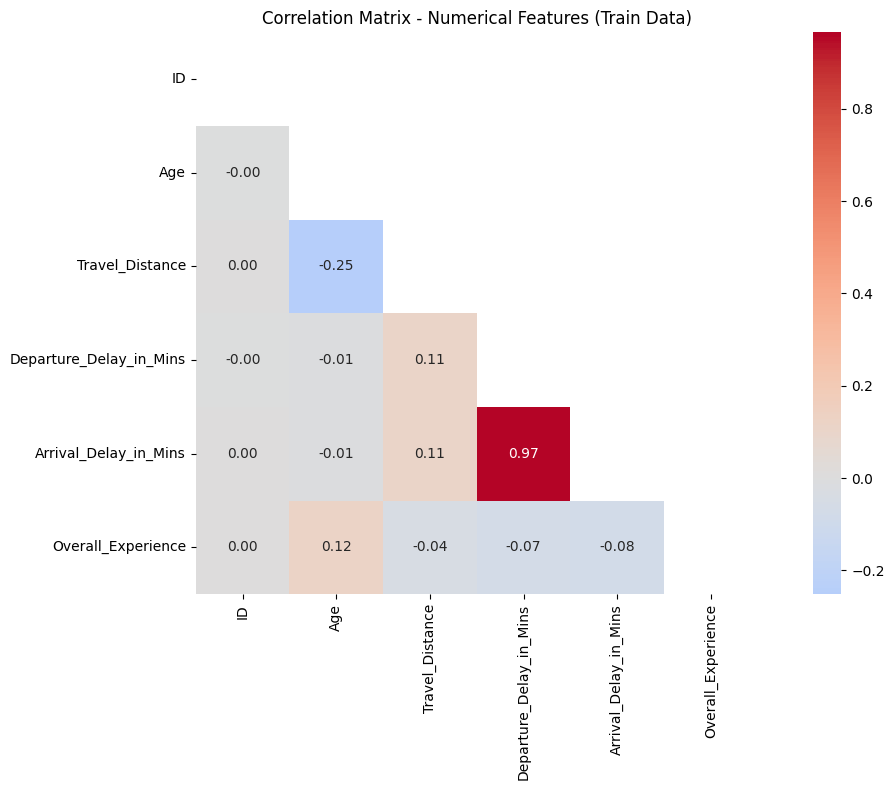

High Correlation Alert (>0.8):
   Departure_Delay_in_Mins - Arrival_Delay_in_Mins: 0.965


In [ ]:
# Correlation analysis on numerical features in the training data
numerical_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

if len(numerical_cols) > 1:
    plt.figure(figsize=(12, 8))

    # Compute correlation matrix
    corr_matrix = train_df[numerical_cols].corr()

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Plot the heatmap
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm',
                center=0, fmt='.2f', square=True)
    plt.title('Correlation Matrix - Numerical Features (Train Data)')
    plt.tight_layout()
    plt.show()

    # Warn if high correlation pairs exist
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.8:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

    if high_corr_pairs:
        print("High Correlation Alert (>0.8):")
        for col1, col2, corr in high_corr_pairs:
            print(f"   {col1} - {col2}: {corr:.3f}")

In [ ]:
class AdvancedFeatureEngineer:
    """Advanced feature engineering for Shinkansen dataset"""

    def __init__(self, df, target_col=TARGET):
        self.df = df.copy()
        self.target_col = target_col
        self.service_rating_cols = [
            'Seat_Comfort', 'Catering', 'Platform_Location', 'Onboard_Wifi_Service',
            'Onboard_Entertainment', 'Online_Support', 'Ease_of_Online_Booking',
            'Onboard_Service', 'Legroom', 'Baggage_Handling', 'CheckIn_Service',
            'Cleanliness', 'Online_Boarding', 'Arrival_Time_Convenient'
        ]
        self.service_rating_cols = [col for col in self.service_rating_cols if col in df.columns]
        self.numerical_cols = []
        self.categorical_cols = []

    def engineer_all_features(self):
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import RobustScaler

        print("Starting advanced feature engineering...")
        df = self.df.copy()
        original_shape = df.shape

        # Drop missing values
        df = df.dropna()

        # Scaling selected numeric columns
        numeric_cols = ['Age', 'Speed_Consistency', 'Train_Delay', 'Arrival_Delay', 'Departure_Delay']
        scaler = RobustScaler()
        scaled = scaler.fit_transform(df[numeric_cols])
        scaled_df = pd.DataFrame(scaled, columns=[f"scaled_{col}" for col in numeric_cols], index=df.index)
        df = pd.concat([df, scaled_df], axis=1)

        # Clustering based on scaled features
        cluster_features = scaled_df.copy()
        kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE)
        df['Cluster'] = kmeans.fit_predict(cluster_features)

        # Optional binary-class interaction
        if 'Travel_Class' in df.columns and 'Catering' in df.columns:
            df['Catering_Premium'] = df['Travel_Class'].astype(str) + '_' + df['Catering'].astype(str)

        # Apply additional feature engineering methods
        df = self.engineer_delay_features(df)
        df = self.engineer_travel_features(df)
        df = self.engineer_service_features(df)
        df = self.engineer_interaction_features(df)
        df = self.engineer_cluster_feature(df)  # Keep PCA clustering if needed

        print(f"Feature engineering complete.")
        print(f"Original shape: {original_shape}")
        print(f"New shape: {df.shape}")
        print(f"Features added: {df.shape[1] - original_shape[1]}")

        return df

In [ ]:
class AdvancedPreprocessor:
    """Advanced preprocessing pipeline"""

    def __init__(self, target_col='Overall_Experience', pca_components=2, n_clusters=4):
        self.target_col = target_col
        self.label_encoders = {}
        self.target_encoder = None
        self.feature_selector = None
        self.numerical_imputers = {}
        self.categorical_imputers = {}
        self.scaler = None # Add a scaler attribute
        self.pca = None # Add PCA attribute
        self.kmeans = None # Add KMeans attribute
        self.pca_components = pca_components # Store PCA components
        self.n_clusters = n_clusters # Store number of clusters
        self.fitted = False
        # Store fitted columns to ensure consistency during transform
        self.fitted_feature_cols = None
        self.fitted_numerical_cols = None
        self.fitted_categorical_cols = None
        self.selection_k = 50 # Store selection_k used during fit
        self.fitted_numerical_cols_before_pca = None # Store numeric cols before PCA

    def fit(self, df, selection_k=50):
        """Fits the preprocessor on the training data."""
        df = df.copy()
        self.selection_k = selection_k # Store selection_k

        # Ensure target column exists for fitting
        if self.target_col not in df.columns:
             print(f"Warning: Target column '{self.target_col}' not found in the dataframe during fit.")
             y = None
             feature_cols = [col for col in df.columns if col not in ['ID']]
        else:
             feature_cols = [col for col in df.columns if col not in [self.target_col, 'ID']]
             y = df[self.target_col].copy()

             # Fit target encoder if target is categorical
             if y.dtype == 'object':
                 self.target_encoder = LabelEncoder()
                 # Handle NaNs in target if necessary, though unlikely for a target
                 y_cleaned = y.dropna()
                 if len(y_cleaned) > 0:
                     self.target_encoder.fit(y_cleaned)
                 else:
                     print(f"Warning: Target column '{self.target_col}' is all NaNs. Cannot fit target encoder.")


        X = df[feature_cols].copy()
        self.fitted_feature_cols = X.columns.tolist() # Store columns *before* imputation/encoding


        # Identify initial feature types
        numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

        # Fit imputers
        self.numerical_imputers = {}
        self.categorical_imputers = {}
        for col in numerical_cols:
            if X[col].isnull().sum() > 0:
                missing_pct = X[col].isnull().sum() / len(X)
                if missing_pct < 0.1:
                    imputer = SimpleImputer(strategy='median')
                    imputer.fit(X[[col]])
                    self.numerical_imputers[col] = imputer
                    # print(f"Fitted median imputer for {col}")
                else:
                    imputer = KNNImputer(n_neighbors=5)
                    imputer.fit(X[[col]])
                    self.numerical_imputers[col] = imputer
                    # print(f"Fitted KNN imputer for {col}")


        for col in categorical_cols:
             if X[col].isnull().sum() > 0:
                 imputer = SimpleImputer(strategy='most_frequent')
                 # Fit on non-NaN values
                 imputer.fit(X[[col]].dropna())
                 self.categorical_imputers[col] = imputer
                 # print(f"Fitted mode imputer for {col}")


        # Fit label encoders (need to handle potential NaNs during fit)
        self.label_encoders = {}
        # Only attempt to encode columns that are currently in X and are categorical
        categorical_cols_to_encode = [col for col in categorical_cols if col in X.columns]
        for col in categorical_cols_to_encode:
             try:
                 le = LabelEncoder()
                 # Handle NaNs before fitting label encoder - fill with a placeholder
                 # Fit on non-NaN values + placeholder
                 fit_values = X[col].dropna().tolist()
                 if '__NaN__' not in fit_values:
                     fit_values.append('__NaN__')
                 le.fit(fit_values)

                 if len(le.classes_) > 1: # Only store if there's more than one effective class
                     self.label_encoders[col] = le
                     # print(f"Fitted label encoder for {col}")
                 else:
                      print(f"Skipping label encoder for {col}: only one unique value found after NaN handling during fit.")

             except Exception as e:
                 print(f"Warning: Label encoder fitting failed for {col}: {e}")

        # --- Preprocessing steps applied for Feature Selection / PCA / KMeans ---
        # Apply fitted imputers and encoders temporarily for subsequent steps
        X_temp = X.copy()
        numerical_cols_temp = X_temp.select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols_temp = X_temp.select_dtypes(include=['object', 'category']).columns.tolist()


        # Impute numerical columns
        for col in numerical_cols_temp:
             if col in self.numerical_imputers:
                 try:
                     X_temp[col] = self.numerical_imputers[col].transform(X_temp[[col]])[:, 0]
                 except Exception as e:
                      print(f"Warning: Imputation transform failed during fit for numerical column {col}: {e}")


        for col in categorical_cols_temp:
            if col in self.categorical_imputers:
                 try:
                     X_temp[col] = self.categorical_imputers[col].transform(X_temp[[col]])[:, 0]
                 except Exception as e:
                      print(f"Warning: Imputation transform failed during fit for categorical column {col}: {e}")


        # Encode categorical columns
        categorical_cols_temp_after_imputation = X_temp.select_dtypes(include=['object', 'category']).columns.tolist()
        for col in categorical_cols_temp_after_imputation:
            if col in self.label_encoders:
                 le = self.label_encoders[col]
                 try:
                     # Use the placeholder used during fit
                     X_temp[col] = X_temp[col].fillna('__NaN__').astype(str)
                     # Handle unseen labels during transform by mapping to the placeholder
                     X_temp[col] = X_temp[col].map(lambda s: s if s in le.classes_ else '__NaN__')
                     X_temp[col] = le.transform(X_temp[col])
                 except Exception as e:
                      print(f"Warning: Label encoding transform failed during fit for {col}: {e}. Dropping column.")
                      # Drop column if encoding fails
                      if col in X_temp.columns:
                           X_temp.drop(columns=[col], inplace=True)


        # Drop any remaining non-numeric columns for subsequent steps
        non_numeric_cols_after_encoding = X_temp.select_dtypes(include=['object', 'category']).columns.tolist()
        if non_numeric_cols_after_encoding:
             print(f"Warning: Dropping non-numeric columns after encoding during fit: {non_numeric_cols_after_encoding}")
             X_temp.drop(columns=non_numeric_cols_after_encoding, inplace=True)

        # Extract numeric columns after imputation and encoding
        X_temp_numeric_only = X_temp.select_dtypes(include=[np.number])

        # --- ADDED: Final robust fillna for any numerical NaNs BEFORE scaling/PCA ---
        # This ensures the input to the scaler and PCA is NaN-free.
        for col in X_temp_numeric_only.columns:
             if X_temp_numeric_only[col].isnull().sum() > 0:
                  print(f"Warning: Column '{col}' still has NaNs before scaling/PCA during fit. Applying final median/0 fill.")
                  X_temp_numeric_only[col] = X_temp_numeric_only[col].fillna(X_temp_numeric_only[col].median() if X_temp_numeric_only[col].median() is not np.nan else 0)
        # --- END ADDED ---


        # Store numerical columns *before* PCA for reference during transform
        self.fitted_numerical_cols_before_pca = X_temp_numeric_only.columns.tolist()


        # Fit Scaler on cleaned numerical data
        if not X_temp_numeric_only.empty: # Check if there are any numeric columns left
             self.scaler = RobustScaler()
             try:
                  self.scaler.fit(X_temp_numeric_only)
                  X_scaled = self.scaler.transform(X_temp_numeric_only)
                  X_scaled_df = pd.DataFrame(X_scaled, columns=X_temp_numeric_only.columns, index=X_temp_numeric_only.index) # Keep original column names for PCA/KMeans


                  # Fit PCA on scaled numerical data
                  if self.pca_components > 0 and X_scaled_df.shape[1] >= self.pca_components:
                      print(f"Fitting PCA with {self.pca_components} components...")
                      self.pca = PCA(n_components=self.pca_components, random_state=RANDOM_STATE)
                      self.pca.fit(X_scaled_df)
                      print("PCA fitted.")
                  else:
                      print(f"Skipping PCA fit: Not enough features ({X_scaled_df.shape[1]}) or pca_components ({self.pca_components}) <= 0.")
                      self.pca = None

                  # Fit KMeans on scaled numerical data (potentially with PCA components)
                  kmeans_input = X_scaled_df.copy()
                  if self.pca:
                      print("Fitting KMeans on PCA transformed data...")
                      # Use PCA transformed data for KMeans fit
                      # Ensure data for KMeans also has original index
                      kmeans_input = pd.DataFrame(self.pca.transform(X_scaled_df), index=X_scaled_df.index)
                  else:
                       print("Fitting KMeans on scaled data...")

                  # Ensure enough samples for KMeans
                  if len(kmeans_input) >= self.n_clusters:
                       try:
                           self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=RANDOM_STATE, n_init=10) # Add n_init
                           self.kmeans.fit(kmeans_input)
                           print("KMeans fitted.")
                       except Exception as e:
                            print(f"Warning: KMeans fitting failed: {e}. Skipping KMeans.")
                            self.kmeans = None
                  else:
                       print(f"Skipping KMeans fit: Not enough samples ({len(kmeans_input)}) for {self.n_clusters} clusters.")
                       self.kmeans = None
             except Exception as e:
                 print(f"Warning: Scaling/PCA/KMeans fitting failed: {e}. Skipping these steps.")
                 self.scaler = None
                 self.pca = None
                 self.kmeans = None
        else:
            print("Warning: No numerical columns found after preprocessing steps during fit. Skipping Scaling, PCA, and KMeans.")
            self.scaler = None
            self.pca = None
            self.kmeans = None


        # Fit feature selection (assuming y is numerical after target encoding)
        # Prepare data for feature selection - use the fully preprocessed, scaled, PCA'd, and clustered data
        # Need to call transform(..., apply_feature_selection=False) to get the data *after* scaling, PCA, KMeans
        # but *before* the final feature selection step itself.
        # This means we need to call transform internally during fit, which is a bit complex.

        # Simpler approach: Apply the full preprocessing chain *except* the final feature selection
        # to a copy of the data, then use that result for feature selection fitting.
        X_temp_for_fs = X.copy()

        # Apply imputation
        numerical_cols_temp_fs = X_temp_for_fs.select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols_temp_fs = X_temp_for_fs.select_dtypes(include=['object', 'category']).columns.tolist()
        for col in numerical_cols_temp_fs:
             if col in self.numerical_imputers:
                 X_temp_for_fs[col] = self.numerical_imputers[col].transform(X_temp_for_fs[[col]])[:, 0]
        for col in categorical_cols_temp_fs:
             if col in self.categorical_imputers:
                 X_temp_for_fs[col] = self.categorical_imputers[col].transform(X_temp_for_fs[[col]])[:, 0]

        # Apply encoding
        categorical_cols_after_imputation_fs = X_temp_for_fs.select_dtypes(include=['object', 'category']).columns.tolist()
        for col in categorical_cols_after_imputation_fs:
            if col in self.label_encoders:
                 le = self.label_encoders[col]
                 X_temp_for_fs[col] = X_temp_for_fs[col].fillna('__NaN__').astype(str)
                 X_temp_for_fs[col] = le.transform(X_temp_for_fs[col].map(lambda s: s if s in le.classes_ else '__NaN__'))

        # Drop remaining non-numeric
        non_numeric_cols_after_encoding_fs = X_temp_for_fs.select_dtypes(include=['object', 'category']).columns.tolist()
        if non_numeric_cols_after_encoding_fs:
             X_temp_for_fs.drop(columns=non_numeric_cols_after_encoding_fs, inplace=True)

        # Final fillna before scaling for FS data
        numerical_cols_before_scaling_fs = X_temp_for_fs.select_dtypes(include=[np.number]).columns.tolist()
        for col in numerical_cols_before_scaling_fs:
             if X_temp_for_fs[col].isnull().sum() > 0:
                  X_temp_for_fs[col] = X_temp_for_fs[col].fillna(X_temp_for_fs[col].median() if X_temp_for_fs[col].median() is not np.nan else 0)


        # Apply Scaling for FS data
        X_scaled_fs = X_temp_for_fs.copy() # Start with imputed/encoded/filled numeric data
        if self.scaler and len(X_scaled_fs.columns) > 0:
            try:
                # Ensure column order matches fitted scaler
                cols_to_scale = list(self.scaler.feature_names_in_) if hasattr(self.scaler, 'feature_names_in_') else X_scaled_fs.columns.tolist()
                # Ensure these columns are in X_scaled_fs
                cols_to_scale = [col for col in cols_to_scale if col in X_scaled_fs.columns]
                if cols_to_scale:
                    X_scaled_transformed = self.scaler.transform(X_scaled_fs[cols_to_scale])
                    X_scaled_fs = pd.DataFrame(X_scaled_transformed, columns=cols_to_scale, index=X_scaled_fs.index)
                else:
                    print("Warning: No columns available for scaling during FS fit preparation.")
            except Exception as e:
                 print(f"Warning: Scaling transform failed during feature selection fit preparation: {e}. Proceeding with unscaled data for FS.")
                 # Keep X_scaled_fs as the pre-scaled data if scaling fails

        # Apply PCA for FS data
        X_pca_input_fs = X_scaled_fs.copy()
        if self.pca:
            try:
                 # Ensure the number of features matches the fitted PCA's expectation
                 if hasattr(self.pca, 'feature_names_in_'):
                     expected_cols = list(self.pca.feature_names_in_)
                     missing_cols_pca = set(expected_cols) - set(X_pca_input_fs.columns)
                     if missing_cols_pca:
                         print(f"Warning: PCA expected columns {missing_cols_pca} not found in FS fit prep data. Skipping PCA for FS data.")
                     else:
                          X_pca_input_fs = X_pca_input_fs[expected_cols]

                 if X_pca_input_fs.shape[1] >= self.pca.n_components_: # Check input shape against PCA output shape
                     X_pca_transformed_fs = self.pca.transform(X_pca_input_fs)
                     pca_cols_fs = [f"PCA_{i+1}" for i in range(X_pca_transformed_fs.shape[1])]
                     X_pca_df_fs = pd.DataFrame(X_pca_transformed_fs, columns=pca_cols_fs, index=X_pca_input_fs.index)
                     X_pca_input_fs = X_pca_df_fs # Use PCA data for KMeans/FS
                 else:
                      print(f"Warning: PCA transform shape mismatch during FS fit prep ({X_pca_input_fs.shape[1]} input features vs {self.pca.n_components_} expected for PCA output). Skipping PCA for FS data.")

            except Exception as e:
                 print(f"Warning: PCA transform failed during FS fit prep: {e}. Skipping PCA for FS data.")


        # Apply KMeans for FS data
        X_kmeans_input_fs = X_pca_input_fs.copy() # Use PCA data if successful, else scaled
        if self.kmeans:
            try:
                 # Ensure the number of features matches the fitted KMeans' expectation
                 if hasattr(self.kmeans, 'feature_names_in_'):
                      expected_cols_kmeans = list(self.kmeans.feature_names_in_)
                      missing_cols_kmeans = set(expected_cols_kmeans) - set(X_kmeans_input_fs.columns)
                      if missing_cols_kmeans:
                           print(f"Warning: KMeans expected columns {missing_cols_kmeans} not found in FS fit prep data. Skipping KMeans feature for FS data.")
                      else:
                           X_kmeans_input_fs = X_kmeans_input_fs[expected_cols_kmeans]


                 if X_kmeans_input_fs.shape[1] == self.kmeans.n_features_in_:
                      cluster_labels_fs = self.kmeans.predict(X_kmeans_input_fs)
                      X_kmeans_input_fs['Cluster'] = cluster_labels_fs
                 else:
                      print(f"Warning: KMeans transform shape mismatch during FS fit prep ({X_kmeans_input_fs.shape[1]} input features vs {self.kmeans.n_features_in_} expected by KMeans). Skipping KMeans feature for FS data.")
            except Exception as e:
                 print(f"Warning: KMeans transform failed during FS fit prep: {e}. Skipping KMeans feature for FS data.")


        # Now perform feature selection fitting using the prepared data (X_kmeans_input_fs)
        if y is not None:
            try:
                X_fs = X_kmeans_input_fs.copy() # Use the final prepared data
                y_numeric = y # y should already be numerical after target encoding if it was object

                # Drop non-numeric columns if any somehow remain
                X_fs = X_fs.select_dtypes(include=np.number)

                # Ensure k is not greater than the number of features available
                k_to_select = min(self.selection_k, X_fs.shape[1])

                if X_fs.shape[1] > 1 and k_to_select > 0 and len(X_fs) > 0 : # Added check for > 1 feature
                    print(f"Fitting feature selection: top {k_to_select} features")
                    # Ensure y is numeric and has the same index as X_fs
                    y_numeric_aligned = y_numeric.loc[X_fs.index]

                    # Ensure no NaNs in y_numeric_aligned
                    if y_numeric_aligned.isnull().sum() > 0:
                         print("Warning: NaNs found in y for feature selection. Dropping rows with NaN target.")
                         nan_indices = y_numeric_aligned[y_numeric_aligned.isnull()].index
                         X_fs = X_fs.drop(nan_indices)
                         y_numeric_aligned = y_numeric_aligned.drop(nan_indices)


                    if len(y_numeric_aligned) > 0 and len(X_fs) == len(y_numeric_aligned):
                         # Check if there are infinite values or NaNs in X_fs before fitting SelectKBest
                         if not np.isfinite(X_fs).all().all() or X_fs.isnull().sum().sum() > 0:
                              print("Warning: Non-finite or NaN values found in X_fs before feature selection. Applying robust fill.")
                              # Replace inf with a large number or median/mean
                              X_fs = X_fs.replace([np.inf, -np.inf], X_fs.median() if X_fs.median() is not np.nan else 0)
                              # Re-check for NaNs after replacing inf
                              X_fs = X_fs.fillna(X_fs.median() if X_fs.median() is not np.nan else 0)


                         # Ensure X_fs still has columns after potential drops/fills
                         if X_fs.shape[1] > 0:
                              # SelectKBest expects non-negative features for f_classif. Check for negative values.
                              if (X_fs < 0).any().any():
                                  print("Warning: Negative values found in X_fs before feature selection. Using mutual_info_classif instead of f_classif.")
                                  score_func = mutual_info_classif
                              else:
                                  score_func = f_classif

                              selector = SelectKBest(score_func=score_func, k=k_to_select)
                              selector.fit(X_fs, y_numeric_aligned)
                              self.feature_selector = selector
                              print("Feature selector fitted.")
                         else:
                              print("Skipping feature selection fit: No features remaining after cleaning.")
                              self.feature_selector = None

                    else:
                        print(f"Skipping feature selection fit: Insufficient valid samples ({len(y_numeric_aligned)}) or mismatch between X and y length ({len(X_fs)} vs {len(y_numeric_aligned)}).")
                        self.feature_selector = None

                else:
                    print(f"Skipping feature selection: number of features ({X_fs.shape[1]}) <= 1 or selection_k ({self.selection_k}) <= 0 or no data.")
                    self.feature_selector = None

            except Exception as e:
                print(f"Warning: Feature selection fitting failed: {e}")
                self.feature_selector = None
        else:
            print("Skipping feature selection fit: Target column not available.")
            self.feature_selector = None


        self.fitted = True
        print("Preprocessor fitted.")

    def transform(self, df, apply_feature_selection=True):
        """Transforms the data using the fitted preprocessor."""
        if not self.fitted:
            raise RuntimeError("Preprocessor has not been fitted yet. Call .fit() first.")

        df = df.copy()
        original_ids = None # Store original IDs
        original_index = df.index # Store original index


        # Separate features and target (if target exists)
        y = None
        if self.target_col in df.columns:
            feature_cols = [col for col in df.columns if col not in [self.target_col, 'ID']]
            X = df[feature_cols].copy()
            y = df[self.target_col].copy()
            original_ids = df['ID'].copy()

            # Encode target if encoder was fitted and target exists in df
            if self.target_encoder and y.dtype == 'object':
                 try:
                     # Use transform on the target column
                     y = self.target_encoder.transform(y)
                 except Exception as e:
                      print(f"Warning: Target encoding transform failed: {e}. Keeping original y.")
        else:
            # If target column is not in df (e.g., test set)
            feature_cols = [col for col in df.columns if col not in ['ID']]
            X = df[feature_cols].copy()
            original_ids = df['ID'].copy()


        print(f"Transforming features. Initial X shape: {X.shape}")

        # Ensure X has the same columns as during fit (order and presence)
        # Handle columns missing in the transform data but present during fit
        missing_cols_in_transform = set(self.fitted_feature_cols) - set(X.columns)
        for col in missing_cols_in_transform:
             X[col] = np.nan # Add missing columns and fill with NaN

        # Handle columns present in transform data but not during fit
        extra_cols_in_transform = set(X.columns) - set(self.fitted_feature_cols)
        for col in extra_cols_in_transform:
             print(f"Warning: Column '{col}' found in transform data but not in fit data. Dropping.")
             X.drop(columns=[col], inplace=True)

        # Reorder columns to match the order during fit
        X = X[self.fitted_feature_cols]

        # Restore original index before preprocessing
        X.index = original_index
        if y is not None:
             y.index = original_index
        if original_ids is not None:
             original_ids.index = original_index


        # Re-identify feature types based on the current X (which now matches fitted columns)
        numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()


        # Apply imputation using fitted imputers
        for col in numerical_cols:
             if col in self.numerical_imputers:
                 imputer = self.numerical_imputers[col]
                 try:
                     # Ensure column is numeric before imputation
                     X[col] = pd.to_numeric(X[col], errors='coerce')
                     # Only transform if there are NaNs to impute
                     if X[col].isnull().sum() > 0:
                         X[col] = imputer.transform(X[[col]])[:, 0]
                 except Exception as e:
                      print(f"Warning: Imputation transform failed for numerical column {col}: {e}. Applying fallback fill.")
                      # Final fallback fill for numerical column
                      X[col] = X[col].fillna(X[col].median() if X[col].median() is not np.nan else 0)


        for col in categorical_cols:
            if col in self.categorical_imputers:
                imputer = self.categorical_imputers[col]
                try:
                    # Ensure column is string/object before imputation
                    X[col] = X[col].astype(str) # Coerce to string to handle potential mixed types
                    # Only transform if there are NaNs to impute
                    if X[col].isnull().sum() > 0:
                         # Use the fitted mode from training data
                         # Note: SimpleImputer expects 2D array
                         X[col] = imputer.transform(X[[col]])[:, 0]
                except Exception as e:
                     print(f"Warning: Imputation transform failed for categorical column {col}: {e}. Applying fallback fill.")
                     # Attempt to fill NaNs as a fallback
                     if X[col].isnull().sum() > 0:
                          print(f"Attempting fallback fill for {col} with mode.")
                          # Use the mode from the current column (could be different than train, but safer than error)
                          mode_values = X[col].mode()
                          if len(mode_values) > 0:
                              X[col] = X[col].fillna(mode_values[0])
                          else:
                              X[col] = X[col].fillna('Unknown') # Fallback fill if no mode


        # Apply encoding using fitted encoders
        # Re-identify categorical columns after imputation, as some might have been dropped or changed type due to errors
        categorical_cols_after_imputation = X.select_dtypes(include=['object', 'category']).columns.tolist()
        for col in categorical_cols_after_imputation:
            if col in self.label_encoders:
                 le = self.label_encoders[col]
                 try:
                     # Ensure string type and fill NaNs with placeholder used during fit
                     X[col] = X[col].fillna('__NaN__').astype(str)
                     # Handle unseen labels during transform by mapping to the placeholder
                     X[col] = le.transform(X[col].map(lambda s: s if s in le.classes_ else '__NaN__'))
                 except Exception as e:
                      print(f"Warning: Label encoding transform failed for {col}: {e}. Dropping column.")
                      # Attempt to drop column if encoding consistently fails
                      if col in X.columns:
                           print(f"Dropping column {col} due to encoding failure.")
                           X.drop(columns=[col], inplace=True)


        # Drop any remaining categorical/object columns after attempted encoding
        non_numeric_cols_after_encoding = X.select_dtypes(include=['object', 'category']).columns.tolist()
        if non_numeric_cols_after_encoding:
             print(f"Warning: Dropping non-numeric columns after encoding: {non_numeric_cols_after_encoding}")
             X.drop(columns=non_numeric_cols_after_encoding, inplace=True)

        # Final check and fill for any remaining numerical NaNs after all steps
        # Apply a robust fillna: use median if available, otherwise use 0
        numerical_cols_final_imputed = X.select_dtypes(include=[np.number]).columns.tolist()
        for col in numerical_cols_final_imputed:
             if X[col].isnull().sum() > 0:
                  print(f"Warning: Column '{col}' still has NaNs after preprocessing steps. Applying final median/0 fill.")
                  X[col] = X[col].fillna(X[col].median() if X[col].median() is not np.nan else 0)

        # Ensure X only contains the numerical columns that existed before PCA during fit
        # This prevents issues if new numeric columns were accidentally created or some dropped during transform errors
        X_transformed_output = X.select_dtypes(include=np.number).copy() # Start with the fully imputed/encoded numerical data
        if self.fitted_numerical_cols_before_pca:
             # Ensure all fitted numerical columns exist in X_transformed_output
             missing_fitted_numeric = set(self.fitted_numerical_cols_before_pca) - set(X_transformed_output.columns)
             if missing_fitted_numeric:
                  print(f"Warning: Fitted numerical columns missing in transform data before scaling/PCA: {missing_fitted_numeric}. Cannot proceed with consistent scaling/PCA.")
                  # Handle this case - perhaps raise an error or skip scaling/PCA
                  # For now, we will proceed with available numerical columns, but warn
                  print("Proceeding with available numerical columns, but scaling/PCA may be inconsistent.")
                  numerical_cols_for_scaling = X_transformed_output.columns.tolist() # Use available columns
             else:
                  # Ensure correct order
                  numerical_cols_for_scaling = [col for col in self.fitted_numerical_cols_before_pca if col in X_transformed_output.columns]
                  X_transformed_output = X_transformed_output[numerical_cols_for_scaling].copy()
        else:
             # If no numerical columns were found during fit,
                          numerical_cols_for_scaling = []            # niente da scalare

        # -------- Scaling -------------------------------------------------
        if self.scaler and numerical_cols_for_scaling:
            print("Applying Scaling transform…")
            try:
                arr_scaled = self.scaler.transform(X_transformed_output[numerical_cols_for_scaling])
                X_transformed_output = pd.DataFrame(
                    arr_scaled,
                    columns=numerical_cols_for_scaling,
                    index=X_transformed_output.index
                )
            except Exception as e:
                print(f" Scaling failed: {e}. Proseguo senza scalare.")

        # -------- PCA ------------------------------------------------------
        if self.pca:
            print("Applying PCA transform…")
            try:
                # Mantieni l’ordine colonne usato in fit
                if hasattr(self.pca, "feature_names_in_"):
                    expected = list(self.pca.feature_names_in_)
                    X_transformed_output = X_transformed_output[expected]
                arr_pca = self.pca.transform(X_transformed_output)
                pca_cols = [f"PCA_{i+1}" for i in range(arr_pca.shape[1])]
                X_transformed_output = pd.DataFrame(
                    arr_pca, columns=pca_cols, index=X_transformed_output.index
                )
            except Exception as e:
                print(f" PCA transform failed: {e}. Salto il PCA.")

        # -------- K-Means ---------------------------------------------------
        if self.kmeans:
            print("Applying KMeans transform…")
            try:
                if X_transformed_output.shape[1] == self.kmeans.n_features_in_:
                    X_transformed_output["Cluster"] = self.kmeans.predict(
                        X_transformed_output
                    )
                else:
                    print("  KMeans shape mismatch. Skipped.")
            except Exception as e:
                print(f" KMeans transform failed: {e}. Skipped.")

        # -------- Feature-selection ----------------------------------------
        if apply_feature_selection and self.feature_selector:
            print("Applying feature selection…")
            try:
                arr_fs = self.feature_selector.transform(
                    X_transformed_output.select_dtypes(include=np.number)
                )
                fs_cols = [f"FS_{i+1}" for i in range(arr_fs.shape[1])]
                X_transformed_output = pd.DataFrame(
                    arr_fs, columns=fs_cols, index=X_transformed_output.index
                )
            except Exception as e:
                print(f" Feature-selection failed: {e}. Proseguo senza FS.")

        # -------- Done ------------------------------------------------------
        print(f"Transformation complete. Shape: {X_transformed_output.shape}")
        return X_transformed_output, y, original_ids

    # ----------------------------------------------------------------------
    def fit_transform(self, df, selection_k=50, apply_feature_selection=True):
        """Convenience: fit + transform in un'unica chiamata."""
        self.fit(df, selection_k=selection_k)
        return self.transform(df, apply_feature_selection=apply_feature_selection)

In [ ]:
class AdvancedModelOptimizer:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.models = {}
        self.results = {}

    def optimize_decision_tree(self, X_train, y_train, cv_folds=5):
        print("Optimizing Decision Tree...")
        param_grid = {
            'max_depth': [5, 10, 15, 20, None],
            'min_samples_split': [2, 10, 20],
            'min_samples_leaf': [1, 5, 10],
            'criterion': ['gini', 'entropy'],
            'max_features': ['sqrt', 'log2', None]
        }
        dt = DecisionTreeClassifier(random_state=self.random_state)
        grid_search = GridSearchCV(dt, param_grid, cv=cv_folds, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        self.models['decision_tree'] = best_model
        self.results['decision_tree'] = {
            'best_score': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }
        print(f"Decision Tree optimized. Best CV accuracy: {grid_search.best_score_:.4f}")
        return best_model

    def _optimize_with_optuna(self, model_class, param_func, model_name, X_train, y_train, n_trials=20, cv_folds=5):
        print(f"Optimizing {model_name.replace('_', ' ').title()} with {n_trials} trials...")
        def objective(trial):
            params = param_func(trial)
            model = model_class(**params)
            return cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='accuracy', n_jobs=-1).mean()
        study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=self.random_state))
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        best_model = model_class(**study.best_params)
        best_model.fit(X_train, y_train)
        self.models[model_name] = best_model
        self.results[model_name] = {
            'best_score': study.best_value,
            'best_params': study.best_params
        }
        print(f"{model_name.replace('_', ' ').title()} optimized. Best CV accuracy: {study.best_value:.4f}")
        return best_model

    def optimize_random_forest(self, X_train, y_train, n_trials=20):
        return self._optimize_with_optuna(RandomForestClassifier, lambda trial: {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 5, 30),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'random_state': self.random_state,
            'n_jobs': -1
        }, 'random_forest', X_train, y_train, n_trials)

    def optimize_extra_trees(self, X_train, y_train, n_trials=20):
        return self._optimize_with_optuna(ExtraTreesClassifier, lambda trial: {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 5, 30),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'random_state': self.random_state,
            'n_jobs': -1
        }, 'extra_trees', X_train, y_train, n_trials)

    def optimize_gradient_boosting(self, X_train, y_train, n_trials=20, cv_folds=5): # Add cv_folds parameter
        return self._optimize_with_optuna(GradientBoostingClassifier, lambda trial: {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'random_state': self.random_state
        }, 'gradient_boosting', X_train, y_train, n_trials, cv_folds) # Pass cv_folds to _optimize_with_optuna

    def optimize_xgboost(self, X_train, y_train, n_trials=20, cv_folds=5): # Added cv_folds here
        return self._optimize_with_optuna(XGBClassifier, lambda trial: {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'use_label_encoder': False,
            'eval_metric': 'logloss',
            'random_state': self.random_state
        }, 'xgboost', X_train, y_train, n_trials, cv_folds) # Pass cv_folds here

    def optimize_lightgbm(self, X_train, y_train, n_trials=20, cv_folds=5): # Added cv_folds here
        return self._optimize_with_optuna(LGBMClassifier, lambda trial: {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'random_state': self.random_state
        }, 'lightgbm', X_train, y_train, n_trials, cv_folds) # Pass cv_folds here

    def optimize_catboost(self, X_train, y_train, n_trials=20, cv_folds=5): # Added cv_folds here
        return self._optimize_with_optuna(CatBoostClassifier, lambda trial: {
            'iterations': trial.suggest_int('iterations', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'verbose': 0,
            'random_state': self.random_state
        }, 'catboost', X_train, y_train, n_trials, cv_folds) # Pass cv_folds here

    def create_ensemble(self, X_train, y_train):
        print("Creating ensemble from optimized models...")
        estimators = [(name, model) for name, model in self.models.items() if model is not None]
        if len(estimators) >= 2:
            voting_clf = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)
            voting_clf.fit(X_train, y_train)
            score = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
            self.models['ensemble'] = voting_clf
            self.results['ensemble'] = {'best_score': score, 'best_params': 'Ensemble of optimized models'}
            print(f"Ensemble created. Best CV accuracy: {score:.4f}")
            return voting_clf
        else:
            print("Not enough models to create an ensemble.")
            return None

    def summary(self):
        print("\n--- Optimization Summary ---")
        for model_name, result in self.results.items():
            print(f"\nModel: {model_name.replace('_', ' ').title()}")
            print(f"  Best CV Score: {result['best_score']:.4f}")
            print("  Best Parameters:")
            params = result['best_params']
            if isinstance(params, dict):
                for k, v in params.items():
                    print(f"    - {k}: {v}")
            else:
                print(f"    {params}")

In [ ]:
# ============================================================
# 2. DATA PREPROCESSING  (fit SOLO sul train, poi transform)
# ============================================================
print("="*60)
print("DATA PREPROCESSING")
print("="*60)

# --- 0)  Sanity-check su Average_Service_Rating ---------------------
for df_tmp in (train_df_fe, test_df_fe):
    if 'Average_Service_Rating' in df_tmp.columns:
        # forza numerico; eventuali stringhe diventano NaN
        df_tmp['Average_Service_Rating'] = pd.to_numeric(
            df_tmp['Average_Service_Rating'], errors='coerce'
        )

# --- 1)  Istanza del pre-processor ----------------------------------
preprocessor = AdvancedPreprocessor(
    target_col     = TARGET,
    pca_components = 0,     # disattivo PCA
    n_clusters     = 0      # disattivo KMeans
)

# Fit SOLO sul train
preprocessor.fit(train_df_fe, selection_k=0)   # 0 => niente SelectKBest

# Transform (train → valid split)
X_train_processed, y_train_processed, _ = preprocessor.transform(
    train_df_fe,
    apply_feature_selection=False            # mantieni tutte le feature
)

# Train / Validation split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_processed, y_train_processed,
    test_size   = 0.20,
    random_state= RANDOM_STATE,
    stratify    = y_train_processed
)

# Transform test
X_test_processed, _, test_ids = preprocessor.transform(
    test_df_fe,
    apply_feature_selection=False
)

# --- 2)  Report ------------------------------------------------------
print("\nShapes:")
print("  train split :", X_train_split.shape)
print("  valid split :", X_val_split.shape)
print("  test proc. :",  X_test_processed.shape)

print("\nNaN check:")
print("  train split :", X_train_split.isna().sum().sum())
print("  valid split :", X_val_split.isna().sum().sum())
print("  test proc. :",  X_test_processed.isna().sum().sum())

DATA PREPROCESSING
Skipping PCA fit: Not enough features (24) or pca_components (0) <= 0.
Fitting KMeans on scaled data...
Skipping feature selection: number of features (24) <= 1 or selection_k (0) <= 0 or no data.
Preprocessor fitted.
Transforming features. Initial X shape: (94379, 24)
Applying Scaling transform…
✅ Transformation complete. Shape: (94379, 24)
Transforming features. Initial X shape: (35602, 24)
Applying Scaling transform…
✅ Transformation complete. Shape: (35602, 24)

Shapes:
  train split : (75503, 24)
  valid split : (18876, 24)
  test proc. : (35602, 24)

NaN check:
  train split : 0
  valid split : 0
  test proc. : 0


In [ ]:
print(f"Test set entries: {X_test_processed.shape[0]}")

Test set entries: 35602


In [ ]:
# ============================================================
# 3. MODEL OPTIMIZATION
# ============================================================
print("="*60)
print("MODEL OPTIMIZATION")
print("="*60)

import optuna
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

optuna.logging.set_verbosity(optuna.logging.WARNING)

optimizer = AdvancedModelOptimizer(random_state=RANDOM_STATE)

print("\nHyper-parameter search…")

# 1) Single models
gb_model  = optimizer.optimize_gradient_boosting(
    X_train_split, y_train_split,
    n_trials=2,
    cv_folds=5
)

xgb_model = optimizer.optimize_xgboost(
    X_train_split, y_train_split,
    n_trials=2,
    cv_folds=5
)

lgb_model = optimizer.optimize_lightgbm(
    X_train_split, y_train_split,
    n_trials=5,
    cv_folds=5
)

cb_model  = optimizer.optimize_catboost(
    X_train_split, y_train_split,
    n_trials=3,
    cv_folds=5
)

# 2) Stacking ensemble
print("\n  Costruisco lo stacking-ensemble…")
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('cat', cb_model)
    ],
    final_estimator = LogisticRegression(max_iter=400, n_jobs=-1),
    cv              = 5,
    n_jobs          = -1,
    passthrough     = False
)
stacking_model.fit(X_train_split, y_train_split)

optimizer.models['stacking'] = stacking_model
optimizer.results['stacking'] = {
    'best_score' : stacking_model.score(X_val_split, y_val_split),
    'best_params': 'Stacking: xgb + lgb + cat → LR'
}

# 3) Report & best model
print("\nRiepilogo dei modelli:")
optimizer.summary()

best_model_name, best_score, best_model = None, -1, None
for name, res in optimizer.results.items():
    if res['best_score'] > best_score:
        best_model_name = name
        best_score      = res['best_score']
        best_model      = optimizer.models[name]

print("\nMiglior modello:")
print(f"    • Name      : {best_model_name}")
print(f"    • Acc@val   : {best_score:0.4f}")

from sklearn.metrics import classification_report
print("\nClassification report (validation):")
print(classification_report(y_val_split, best_model.predict(X_val_split)))

MODEL OPTIMIZATION

Hyper-parameter search…
Optimizing Gradient Boosting with 2 trials...


  0%|          | 0/2 [00:00<?, ?it/s]

Gradient Boosting optimized. Best CV accuracy: 0.9512
Optimizing Xgboost with 2 trials...


  0%|          | 0/2 [00:00<?, ?it/s]

Xgboost optimized. Best CV accuracy: 0.9523
Optimizing Lightgbm with 5 trials...


  0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 41274, number of negative: 34229
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 963
[LightGBM] [Info] Number of data points in the train set: 75503, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546654 -> initscore=0.187160
[LightGBM] [Info] Start training from score 0.187160
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.4813158	total: 86.7ms	remaining: 21.6s
1:	learn: 0.3785296	total: 125ms	remaining: 15.5s
2:	learn: 0.3127323	total: 164ms	remaining: 13.5s
3:	learn: 0.2614146	total: 200ms	remaining: 12.3s
4:	learn: 0.2352598	total: 238ms	remaining: 11.7s
5:	learn: 0.2212193	total: 303ms	remaining: 12.3s
6:	learn: 0.2106178	total: 341ms	remaining: 11.8s
7:	learn: 0.2029546	total: 382ms	remaining: 11.6s
8:	learn: 0.1942477	total: 419ms	remaining: 11.2s
9:	learn: 0.1884133	total: 456ms	remaining: 11s
10:	learn: 0.1824799	total: 494ms	remaining: 10.7s
11:	learn: 0.1765407	total: 535ms	remaining: 10.6s
12:	learn: 0.1689740	total: 573ms	remaining: 10.4s
13:	learn: 0.1650442	total: 613ms	remaining: 10.3s
14:	learn: 0.1605138	total: 651ms	remaining: 10.2s
15:	learn: 0.1588312	total: 690ms	remaining: 10.1s
16:	learn: 0.1571947	total: 726ms	remaining: 9.95s
17:	learn: 0.1540978	total: 765ms	remaining: 9.86s
18:	learn: 0.1505589	total: 800ms	remaining: 9.73s
19:	learn: 0.1460207	total: 837ms	remainin

In [ ]:
print("Train columns :", list(X_train_split.columns))
print("Test  columns :", list(X_test_processed.columns))
print("Differenze    :", set(X_train_split.columns) ^ set(X_test_processed.columns))

Train columns : ['Gender', 'Customer_Type', 'Age', 'Type_Travel', 'Travel_Class', 'Travel_Distance', 'Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins', 'Seat_Comfort', 'Seat_Class', 'Arrival_Time_Convenient', 'Catering', 'Platform_Location', 'Onboard_Wifi_Service', 'Onboard_Entertainment', 'Online_Support', 'Ease_of_Online_Booking', 'Onboard_Service', 'Legroom', 'Baggage_Handling', 'CheckIn_Service', 'Cleanliness', 'Online_Boarding', 'Catering_Premium']
Test  columns : ['Gender', 'Customer_Type', 'Age', 'Type_Travel', 'Travel_Class', 'Travel_Distance', 'Departure_Delay_in_Mins', 'Arrival_Delay_in_Mins', 'Seat_Comfort', 'Seat_Class', 'Arrival_Time_Convenient', 'Catering', 'Platform_Location', 'Onboard_Wifi_Service', 'Onboard_Entertainment', 'Online_Support', 'Ease_of_Online_Booking', 'Onboard_Service', 'Legroom', 'Baggage_Handling', 'CheckIn_Service', 'Cleanliness', 'Online_Boarding', 'Catering_Premium']
Differenze    : set()


In [ ]:
# 1 Predizione
y_test_preds = best_model.predict(X_test_processed)

# 2 DataFrame di submission
submission_df = pd.DataFrame({
    'ID': test_df['ID'],          # <- intestazione corretta
    'Overall_Experience': y_test_preds
})

# 3 Salvataggio
submission_df.to_csv('submission.csv', index=False)

# 4 Download (se sei in Colab)
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>